In [185]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

In [148]:
def get_X_y(data):
    """"
    Returns the X and y of the data

    :returns X, y
    """
    return data.loc[:, data.columns != 'Classification'], data['Classification']



In [149]:
# Creating the pipeline
features_num = [
    "AGNfrac_af", "AGNfrac_af_16", "AGNfrac_cg_s", "AGNfrac_cg_s_16", "AGNfrac_cg_f", "AGNfrac_cg_f_16", 
    "Chi_sq_MpBp", "Chi_sq_AfCg", "Mass_conc", "SFR_conc", "Radio_excess", "Radio_excess_DJS"
]
features_cat = [
    "Spitzer_SN", "Donley", "Lacy", "Stern", "Messias", "KI", "Ch2_Ch4", 
    "Ch4_24mu", "Xray", "Opt_spec", "Extended_radio"
]
features_drop = [
    "Source_Name", "Radio_ID", "AGN_final", "IDOptical", "IDSpitzer"
]
transformer_num = make_pipeline(
    SimpleImputer(),  # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [150]:
data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")
X, y = get_X_y(data)
X = X.drop(columns=features_drop)

# Transforming y from categorical to numerical
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

C:\Users\jespe\AppData\Local\Temp\ipykernel_3952\22415563.py:1: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")


In [151]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [152]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [153]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [154]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy       0.96      0.99      0.97      3891
quasar-like radio AGN / high-excitation radio galaxy       0.83      0.86      0.84       389
                                     radio-quiet AGN       0.94      0.93      0.93      2052
                                 star-forming galaxy       0.99      0.99      0.99     16951

                                            accuracy                           0.98     23283
                                           macro avg       0.93      0.94      0.93     23283
                                        weighted avg       0.98      0.98      0.98     23283



[]

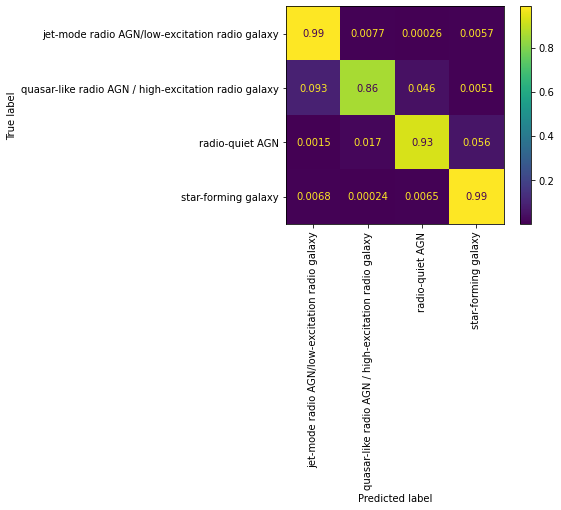

In [188]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [162]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])

[Text(0, 0, 'pipeline-1__AGNfrac_af'),
 Text(1, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(2, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(3, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(4, 0, 'pipeline-1__AGNfrac_cg_f'),
 Text(5, 0, 'pipeline-1__AGNfrac_cg_f_16'),
 Text(6, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(7, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(8, 0, 'pipeline-1__Mass_conc'),
 Text(9, 0, 'pipeline-1__SFR_conc'),
 Text(10, 0, 'pipeline-1__Radio_excess'),
 Text(11, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(12, 0, 'pipeline-2__Spitzer_SN_0.0'),
 Text(13, 0, 'pipeline-2__Spitzer_SN_1.0'),
 Text(14, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(15, 0, 'pipeline-2__Donley_0.0'),
 Text(16, 0, 'pipeline-2__Donley_1.0'),
 Text(17, 0, 'pipeline-2__Lacy_0.0'),
 Text(18, 0, 'pipeline-2__Lacy_1.0'),
 Text(19, 0, 'pipeline-2__Stern_0.0'),
 Text(20, 0, 'pipeline-2__Stern_1.0'),
 Text(21, 0, 'pipeline-2__Messias_0.0'),
 Text(22, 0, 'pipeline-2__Messias_1.0'),
 Text(23, 0, 'pipeline-2__KI_-99.0'),
 Text(24, 0, 'pipeli

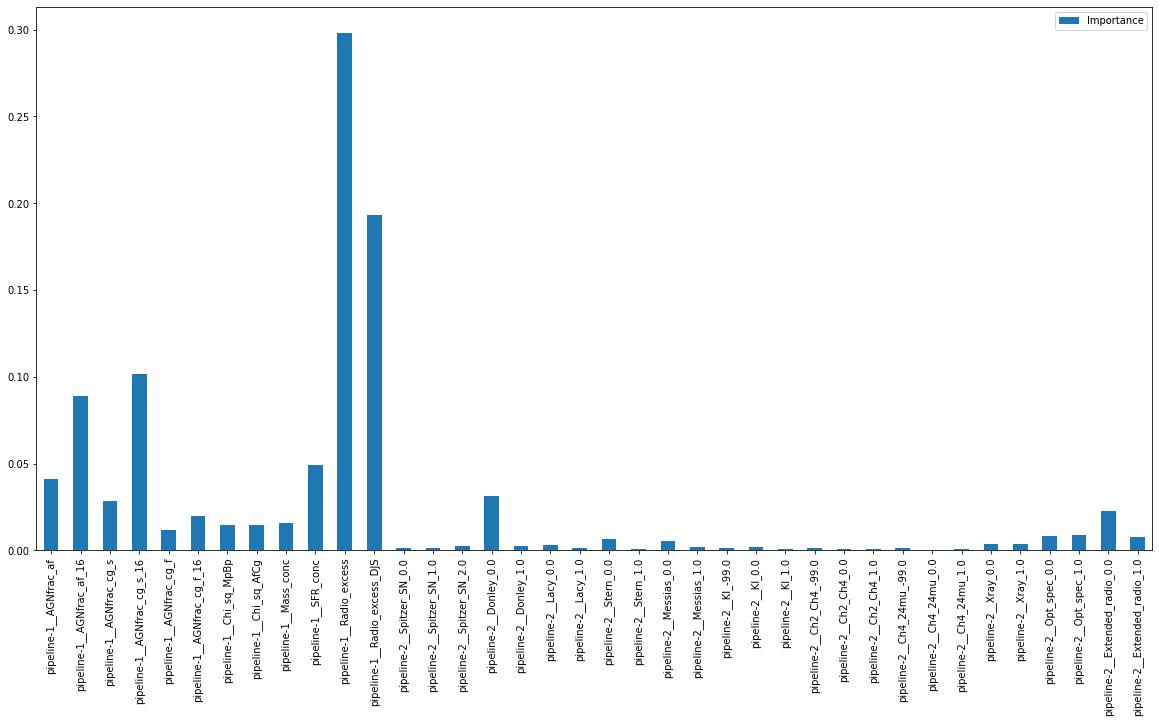

In [169]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)